# Определение возраста покупателей

## Исследовательский анализ данных

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from PIL import Image
from pathlib import Path

from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from pathlib import Path


In [13]:
data_path = Path('../datasets/faces/')

img_df = pd.read_csv(data_path.joinpath('labels.csv'))
# data_path = Path('../datasets/faces/final_files/')


img_df['full_path'] = img_df.file_name.apply(lambda x: data_path.joinpath('final_files/' + x)) # Делаем признак с полным путем к файлу

In [14]:
img_df.head(20)

file_name  real_age                                 full_path
0   000000.jpg         4  ../datasets/faces/final_files/000000.jpg
1   000001.jpg        18  ../datasets/faces/final_files/000001.jpg
2   000002.jpg        80  ../datasets/faces/final_files/000002.jpg
3   000003.jpg        50  ../datasets/faces/final_files/000003.jpg
4   000004.jpg        17  ../datasets/faces/final_files/000004.jpg
5   000005.jpg        27  ../datasets/faces/final_files/000005.jpg
6   000006.jpg        24  ../datasets/faces/final_files/000006.jpg
7   000007.jpg        43  ../datasets/faces/final_files/000007.jpg
8   000008.jpg        26  ../datasets/faces/final_files/000008.jpg
9   000009.jpg        39  ../datasets/faces/final_files/000009.jpg
10  000010.jpg        17  ../datasets/faces/final_files/000010.jpg
11  000011.jpg        51  ../datasets/faces/final_files/000011.jpg
12  000012.jpg         2  ../datasets/faces/final_files/000012.jpg
13  000013.jpg         1  ../datasets/faces/final_files/000013.jpg
14  000014.jpg         6  ../datasets/faces/final_files/000014.jpg
15  000015.jpg        18  ../datasets/faces/final_files/000015.jpg
16  000016.jpg        24  ../datasets/faces/final_files/000016.jpg
17  000017.jpg         5  ../datasets/faces/final_files/000017.jpg
18  000018.jpg        40  ../datasets/faces/final_files/000018.jpg
19  000019.jpg        16  ../datasets/faces/final_files/000019.jpg

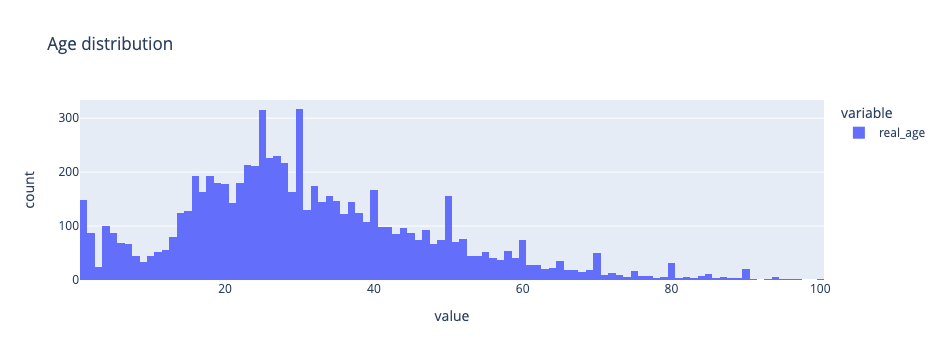

In [15]:
px.histogram(img_df.real_age, title='Age distribution', )

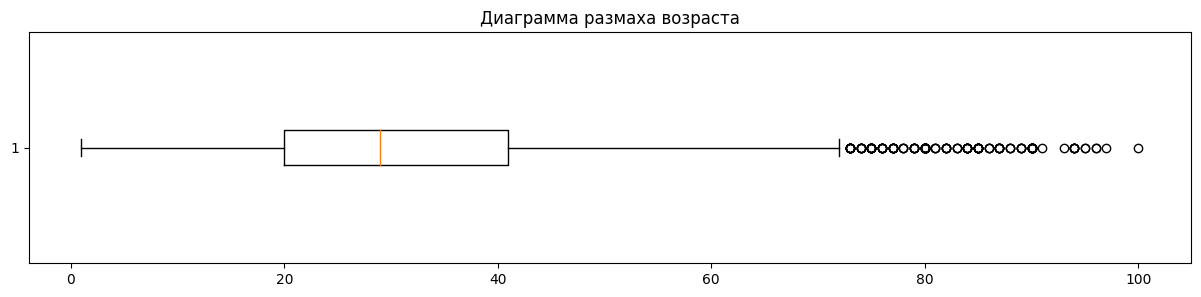

In [16]:
plt.figure(figsize=(15,3))
plt.title('Диаграмма размаха возраста')
plt.boxplot(img_df['real_age'], vert=False);

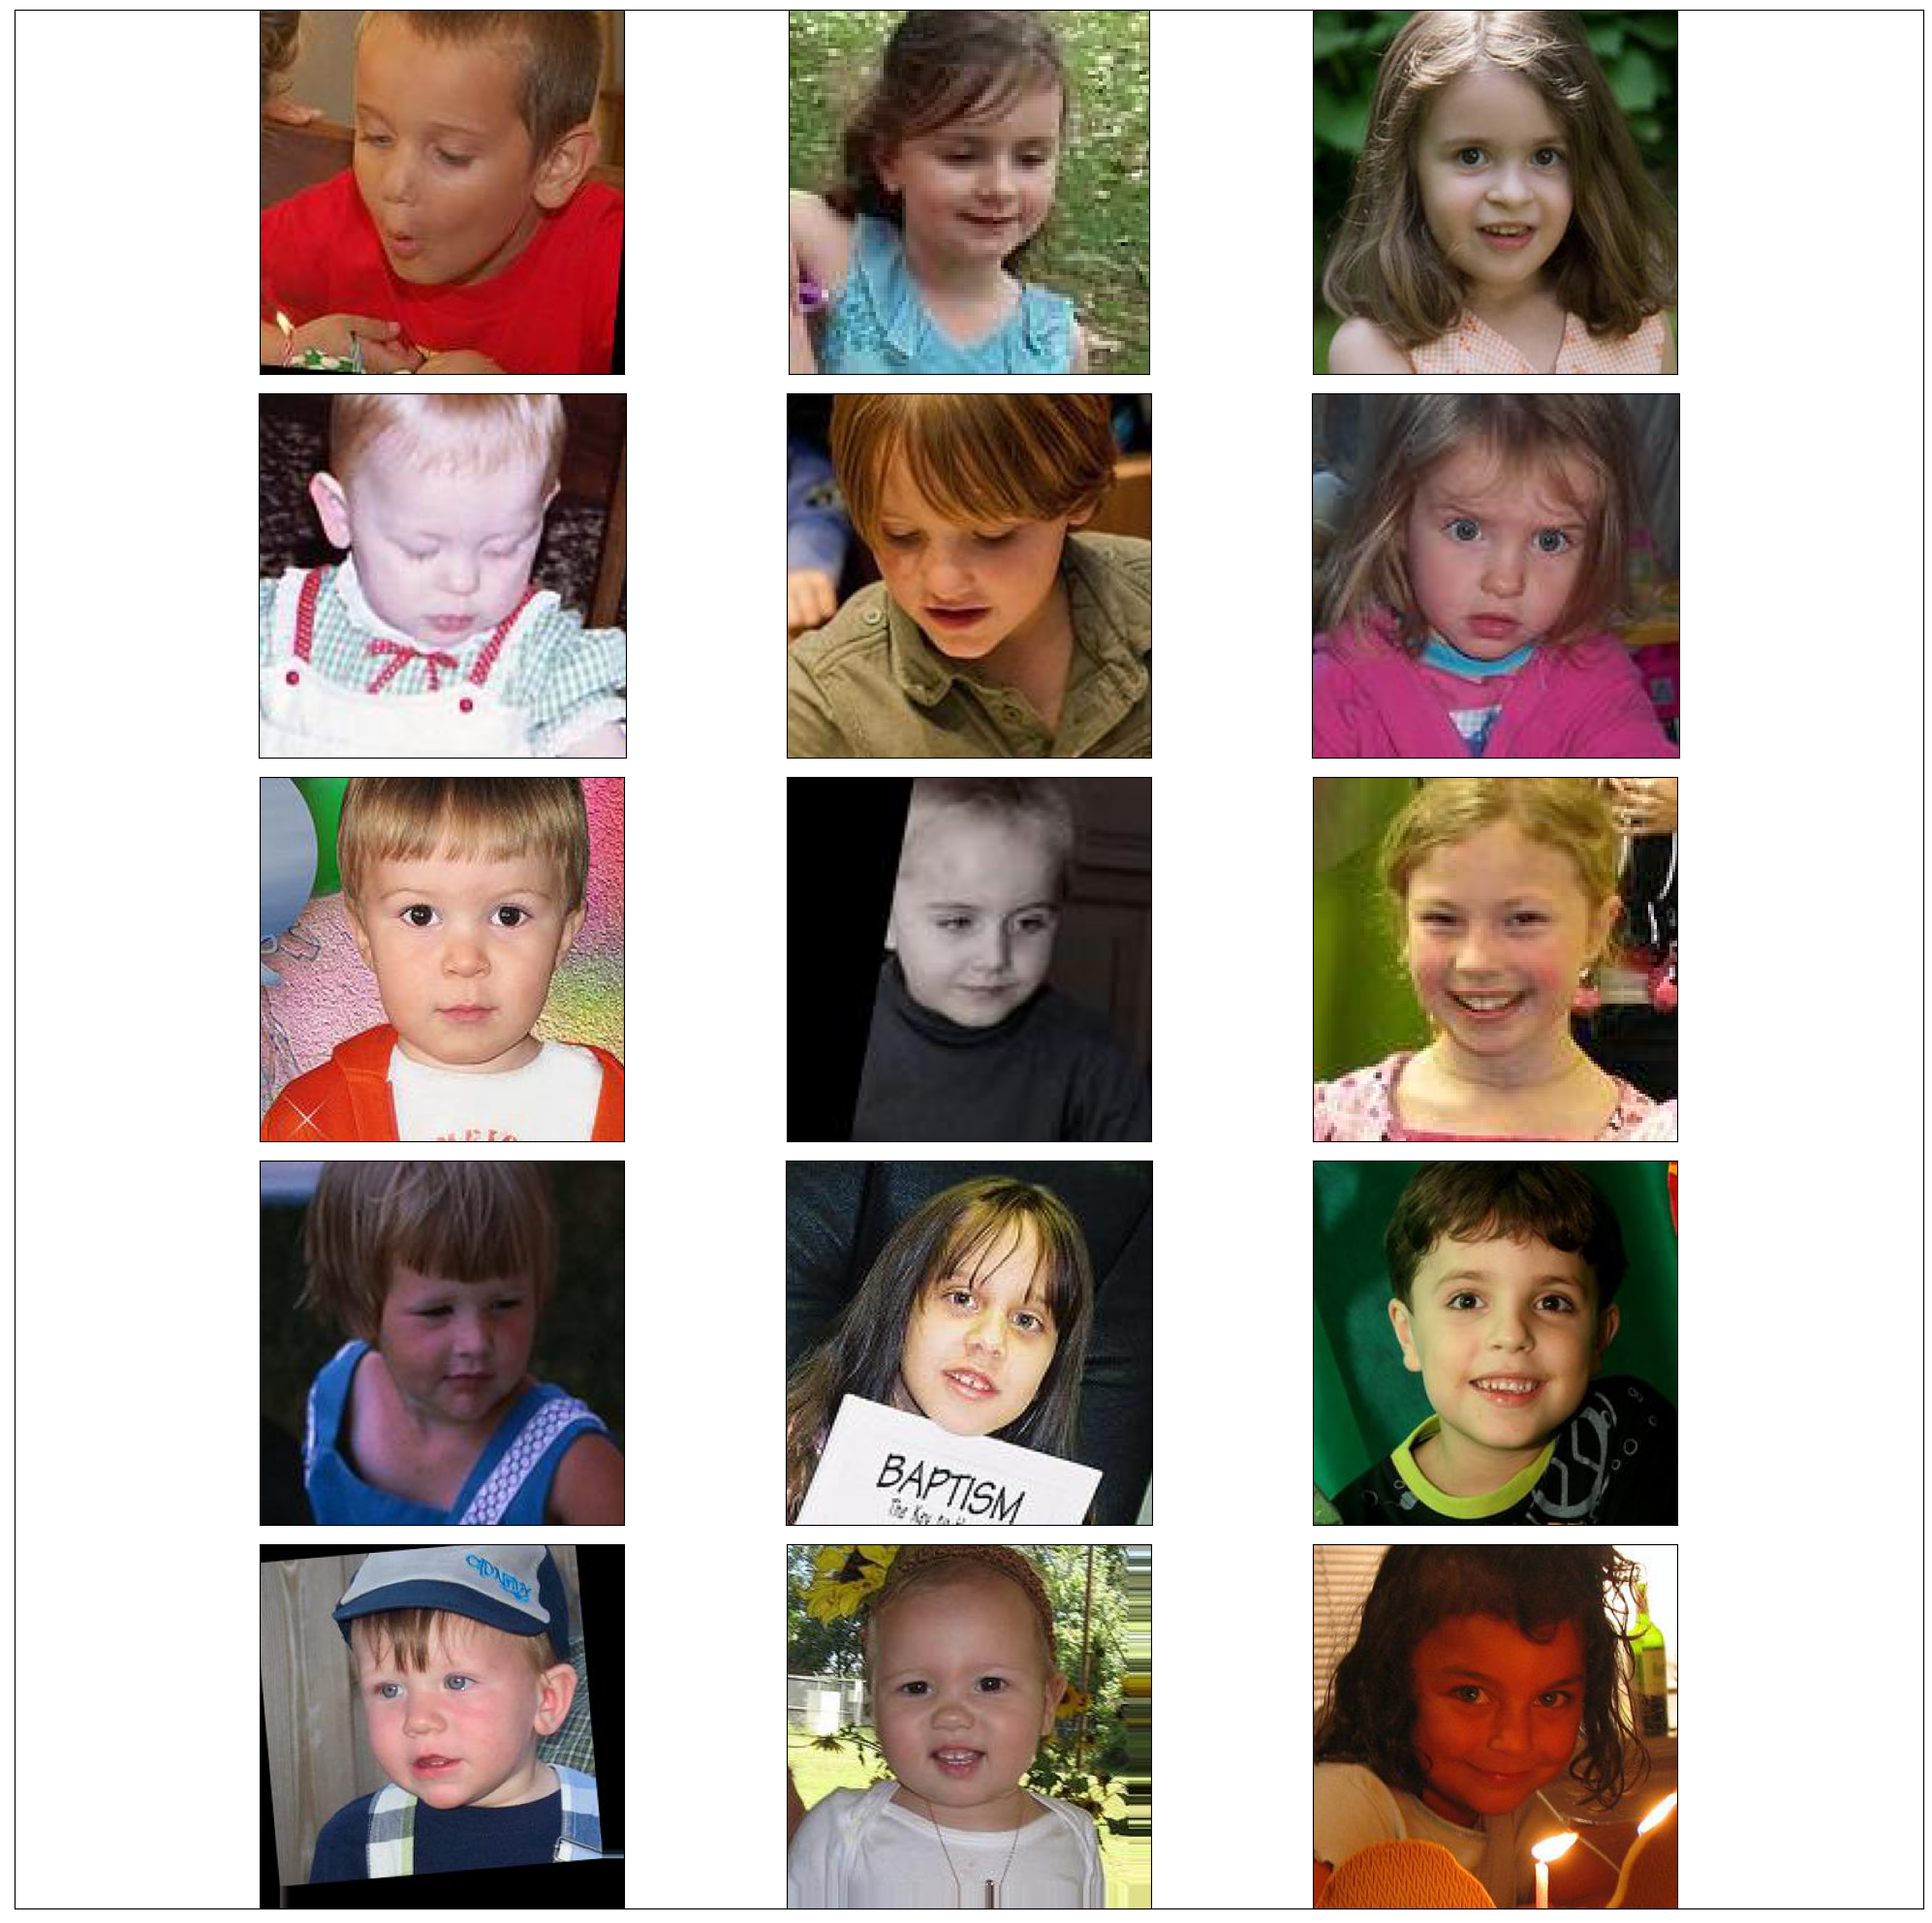

In [17]:
w = 20
h = 20
fig = plt.figure(figsize=(18,8))

columns = 3
rows = 5
plt.xticks([])
plt.yticks([])
img_list = img_df.query("real_age < 9").full_path.to_list()
for i in range(1, columns*rows + 1):
    img = Image.open(np.random.choice(img_list))
    fig.add_subplot(rows, columns, i)
    fig.set_figheight(h)
    fig.set_figwidth(w)
    plt.imshow(img)
    plt.xticks([]) # drop ticks 
    plt.yticks([])
    plt.tight_layout()
plt.show()
    



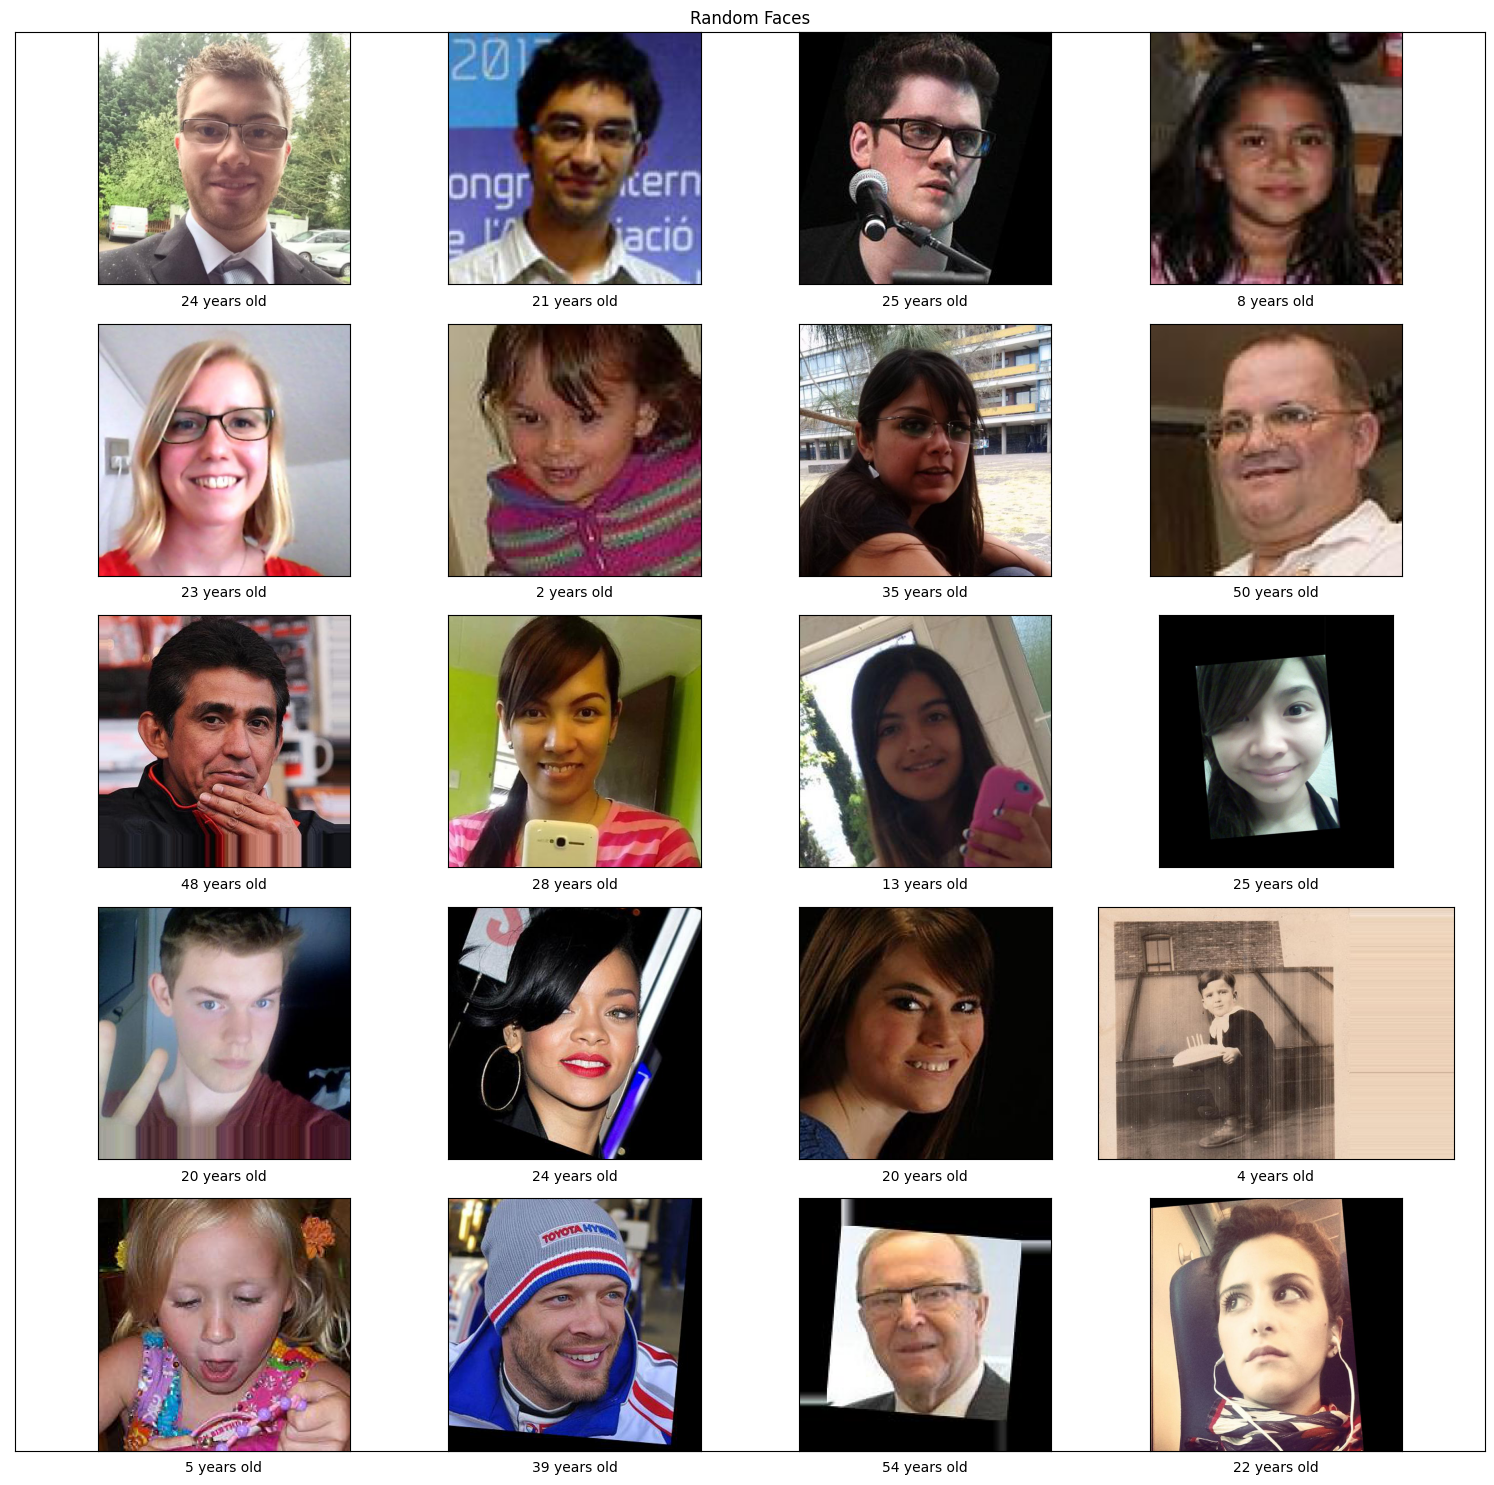

In [18]:
w = 15 # set width to subplot
h = 15 # set height to subplot
fig = plt.figure(figsize=(18,8))
columns = 4
rows = 5
plt.title('Random Faces')
plt.xticks([])
plt.yticks([])
for i in range(1, columns*rows +1):
    rand_n = np.random.randint(img_df.shape[0]) # choose random image from dataset
    img = Image.open(img_df.iloc[rand_n].full_path) # open image
    fig.add_subplot(rows, columns, i) 
    fig.set_figheight(h)
    fig.set_figwidth(w)
    plt.imshow(img)
    plt.xticks([]) # drop ticks 
    plt.yticks([])
    plt.xlabel(f"{img_df.iloc[rand_n].real_age} years old") 
    plt.tight_layout()

plt.show()


In [19]:
print(f'Процент людей младше 9 лет: {img_df.query("real_age <= 9").shape[0] / img_df.shape[0]:.2%}')

Процент людей младше 9 лет: 8.73%


## Выводы:
- Распределение возраста в датасете - близко к нормальному, однако для нашей задачи я бы отсек фото людей младше 9 лет. 
- Судя по фотографиям, датасет уже аугментирован, поэтому при обучении стоит осторожно применять дополнительные аугментации, либо вообще от них отказаться. 

## Обучение модели

In [27]:


from tensorflow.keras.applications.efficientnet import EfficientNetB4

# rescale size for efficientnet
IMG_SIZE = 380


def load_train(path, img_size=(224,224)):
    labels = pd.read_csv(path.joinpath('labels.csv'))
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        horizontal_flip=True,
        rotation_range=20,
        zoom_range=0.2,
        rescale=1./255)
    
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path.joinpath('final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=img_size,
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path, img_size=(224, 224)):
    labels = pd.read_csv(path.joinpath('labels.csv'))
    test_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path.joinpath('final_files/'),
        x_col='file_name',
        y_col='real_age',
        target_size=img_size,
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return test_gen_flow

def create_model(input_shape):
    opt = Adam(learning_rate=0.0001)
    # backbone = ResNet50(input_shape=input_shape,
    #             include_top=False)
    backbone = EfficientNetB4(input_shape=input_shape, include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_absolute_error', optimizer=opt, metrics=['mae'])
    model.summary()
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):
    if steps_per_epoch == None: steps_per_epoch = len(train_data)
    if validation_steps == None: validation_staps = len(test_data)
    
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model 



In [31]:
train_gen = load_train(data_path, img_size=(IMG_SIZE, IMG_SIZE))
test_gen = load_test(data_path, img_size=(IMG_SIZE, IMG_SIZE))

# model = create_model((224,224,3))
model = create_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))

Found 5694 validated image filenames.
Found 1897 validated image filenames.
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb4 (Functional)  (None, 12, 12, 1792)     17673823  
                                                                 
 global_average_pooling2d_3   (None, 1792)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 1)                 1793      
                                                                 
Total params: 17,675,616
Trainable params: 17,550,409
Non-trainable params: 125,207
_________________________________________________________________


In [33]:
# augmentation included
train_model(model, train_gen, test_gen, batch_size=32)

Epoch 1/5


KeyboardInterrupt: 

## output from cloud

```

Train for 356 steps, validate for 119 steps
Epoch 1/5
2022-08-18 14:41:40.446746: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-08-18 14:41:40.782982: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
356/356 - 53s - loss: 10.5930 - mae: 10.5946 - val_loss: 21.8398 - val_mae: 21.8399
Epoch 2/5
356/356 - 41s - loss: 7.5324 - mae: 7.5330 - val_loss: 8.9089 - val_mae: 8.9000
Epoch 3/5
356/356 - 39s - loss: 6.5500 - mae: 6.5504 - val_loss: 6.8547 - val_mae: 6.8519
Epoch 4/5
356/356 - 39s - loss: 5.9053 - mae: 5.9055 - val_loss: 6.9671 - val_mae: 6.9674
Epoch 5/5
356/356 - 39s - loss: 5.3680 - mae: 5.3684 - val_loss: 6.5893 - val_mae: 6.5963
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
119/119 - 10s - loss: 6.5893 - mae: 6.5963
Test MAE: 6.5963

```

## Анализ обученной модели

- Архитектура ResNet50 позволяет достичь впечатляющих результатов, необходимый порог MAE преодален
- К сожалению не удалось попробовать другие архитектуры, такие как efficientnet, т.к. тренажёр не принимает файл с этой архитектурой
- Заказчик вполне может внедрять систему определения возраста, т.к. она имеет довольно высокую точность. Если же после внедрения дополнить датасет фотографиями покупателей из магазина, снова обучить модель, можно добиться снижения метрики MAE.
